# **AT THE INTERSECTION OF DATA: PREDICTING VEHICLE CRASH SEVERITY USING MACHINE LEARNING**

**Spring 2020 ML4VA Project**

**Authors**: Ankit Agrawal (aa6eu), Supriya Savaram (ss6nnd), and Nikita Sivakumar (ns4dg)

**Course**: CS 4774 [Maching Learning], Prof. Rich Nguyen

**GitHub Repository Link for Code**: https://github.com/nikita-sivakumar/ML4VA

# **STEP 1: Big Picture and Setup**

For any future plots or figures, we can setup the colab notebook to properly handle such results. The code below is the same code introduced from the beginning of the course, and specifically pulled from "CS_4774_02_end_to_end_machine_learning_project.ipynb"

In [0]:
# Import the proper packages/libraries #
import sklearn
import numpy as np
import os

# Set the random seed
np.random.seed(4774)

# Handle plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Saving figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ML4VA"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  """Save the selected figure into disc under an image extention and resolution

  Parameters
  ----------
  fig_id : figure handle
    The id number of the figure
  tight_layout : boolean (True or False)
    Specifies whenther the layout should be tight or not
  fig_extension: string
    Under what extension should the file be saved ("png" or "jpg")
  resolution: int
    the quality of the figure (ie. 100,200,300)

  Returns
  -------
  void
    Does not return any value
  """

  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)


In [0]:
# Additional important libraries
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer # Import statement found from Piazza
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# **STEP 2: Get the Data**

Data is uploaded under the name "CrashData_Basic.csv"

In [0]:
import tarfile # to support compressed (tar) files
from six.moves import urllib # support URL download

CRASH_URL = "https://github.com/nikita-sivakumar/ML4VA/blob/master/crashdata.tar.gz?raw=true"
CRASH_PATH = os.path.join("datasets", "crash")

def fetch_crash_data(crash_url=CRASH_URL, crash_path=CRASH_PATH):
    """Fetch housing data from a remote URL to Colab file system"""
    if not os.path.isdir(crash_path):
        os.makedirs(crash_path)
    tgz_path = os.path.join(crash_path, "crash.tgz")
    urllib.request.urlretrieve(crash_url, tgz_path)
    crash_tgz = tarfile.open(tgz_path)
    crash_tgz.extractall(path=crash_path)
    crash_tgz.close()

In [0]:
os.path.join(CRASH_PATH, "crash.tgz")

'datasets/crash/crash.tgz'

In [0]:
fetch_crash_data()

Below is a high level overview of the data upon first downloading it.

In [0]:
crash_path = os.path.join("datasets", "crash","Dropbox","Nikita","College","S4","MachineLearning","ML4VA","CrashData_Basic.csv")
crash = pd.read_csv(crash_path)
crash.head()

,X,Y,OBJECTID,DOCUMENT_NBR,CRASH_YEAR,CRASH_DT,CRASH_MILITARY_TM,CRASH_SEVERITY,K_PEOPLE,A_PEOPLE,B_PEOPLE,C_PEOPLE,PERSONS_INJURED,PEDESTRIANS_KILLED,PEDESTRIANS_INJURED,VEH_COUNT,COLLISION_TYPE,WEATHER_CONDITION,LIGHT_CONDITION,RD_TYPE,ROADWAY_SURFACE_COND,RELATION_TO_ROADWAY,ROADWAY_ALIGNMENT,ROADWAY_SURFACE_TYPE,ROADWAY_DEFECT,ROADWAY_DESCRIPTION,INTERSECTION_TYPE,TRAFFIC_CONTROL_TYPE,TRFC_CTRL_STATUS_TYPE,WORK_ZONE_RELATED,WORK_ZONE_LOCATION,WORK_ZONE_TYPE,FIRST_HARMFUL_EVENT,FIRST_HARMFUL_EVENT_LOC,ALCOHOL_NOTALCOHOL,BELTED_UNBELTED,BIKE_NONBIKE,DISTRACTED_NOTDISTRACTED,DEER_NODEER,DROWSY_NOTDROWSY,DRUG_NODRUG,GR_NOGR,HITRUN_NOT_HITRUN,LGTRUCK_NONLGTRUCK,MOTOR_NONMOTOR,PED_NONPED,RR,SPEED_NOTSPEED,SCHOOL_ZONE,SENIOR_NOTSENIOR,YOUNG_NOTYOUNG,MAINLINE_YN,NIGHT,VDOT_DISTRICT,JURIS_CODE,PHYSICAL_JURIS,LOCAL_CASE_CD,FUN,FAC,AREA_TYPE,SYSTEM,VSP,OWNERSHIP,INTERSECTION_ANALYSIS,PLAN_DISTRICT,MPO_NAME,ROUTE_OR_STREET_NM,RTE_NM,RNS_MP,NODE,OFFSET,LAT,LON
0,-77.220320,38.866336,2001,130485005,2013,2013-02-17T01:00:00.000Z,2202,PDO. Property Damage Only,0,0,0,0,0,0,0,2,1. Rear End,1. No Adverse Condition (Clear/Cloudy),4. Darkness - Road Lighted,NOT_RD,1. Dry,1. Main-Line Roadway,1. Straight - Level,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"3. Two-Way, Divided, Positive Median Barrier",1. Not at Intersection,6. Traffic Lanes Marked,1. Yes - Working,2. No,Not Provided,Not Provided,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,3. No,No,No,Yes,Yes,9. Northern Virginia,29,029. Fairfax County,DIV713021659,A. Urban Interstate,"3. Divided, full control of access",Urban,INTERSTATE,7.0,VDOT_IS,NOT_INTERSECTION,Northern Virginia,Northern Virginia Portion of The Metropolitan ...,I-495 SOUTH,R-VA IS00495SB,7.618688,NaN,NaN,38.866336,-77.220320
1,-77.692049,39.137436,2002,131055143,2013,2013-04-16T00:00:00.000Z,1030,B. Visible Injury,0,0,2,0,2,0,0,2,1. Rear End,1. No Adverse Condition (Clear/Cloudy),2. Daylight,NOT_RD,1. Dry,9. Within Intersection,1. Straight - Level,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"1. Two-Way, Not Divided",3. Three Approaches,3. Traffic Signal,1. Yes - Working,1. Yes,2. Transition Area,3. Work on Shoulder or Median,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,Yes,No,No,No,No,No,Yes,No,No,No,No,3. No,No,No,Yes,No,9. Northern Virginia,53,053. Loudoun County,D13-000028,H. Urban Minor Arterial,"0. Two-way, non-divided",Urban,PRIMARY,7.0,VDOT_PRI,NOT_INTERSECTION,Northern Virginia,Northern Virginia Portion of The Metropolitan ...,287/ BERLIN TURN PIKE,R-VA SR00287NB,0.126632,429738.0,0.127,39.137436,-77.692049
2,-77.182500,38.725000,2003,130940382,2013,2013-01-31T01:00:00.000Z,1745,B. Visible Injury,0,0,1,1,2,0,0,4,1. Rear End,1. No Adverse Condition (Clear/Cloudy),4. Darkness - Road Lighted,NOT_RD,1. Dry,10. Intersection Related - Within 150 Feet,3. Grade - Straight,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"2. Two-Way, Divided, Unprotected Median",4. Four Approaches,3. Traffic Signal,1. Yes - Working,2. No,Not Provided,Not Provided,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3. No,No,No,Yes,Yes,9. Northern Virginia,29,029. Fairfax County,20130300173,H. Urban Minor Arterial,"0. Two-way, non-divided",Urban,SECONDARY,7.0,VDOT_SEC,NOT_INTERSECTION,Northern Virginia,Northern Virginia Portion of The Metropolitan ...,RT.611/TELEGRAPH ROAD,R-VA029SC00611SB,8.200961,704049.0,0.051,38.725000,-77.182500
3,-79.875152,36.692788,2004,130835058,2013,2013-03-23T00:00:00.000Z,1127,PDO. Property Damage Only,0,0,0,0,0,0,0,2,2. Angle,1. No Adverse Condition (Clear/Cloudy),2. Daylight,NOT_RD,1. Dry,9. Within Intersection,1. Straight - Level,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"1. Two-Way, Not Divided",4. Four Approaches,3. Traffic Signal,1. Yes - Working,2. No,Not Provided,Not Provided,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3. No,Yes,No,Yes,No,2. Salem,120,120. City 

In [0]:
crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859972 entries, 0 to 859971
Data columns (total 73 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   X                         859935 non-null  float64
 1   Y                         859935 non-null  float64
 2   OBJECTID                  859972 non-null  int64  
 3   DOCUMENT_NBR              859972 non-null  int64  
 4   CRASH_YEAR                859972 non-null  int64  
 5   CRASH_DT                  859972 non-null  object 
 6   CRASH_MILITARY_TM         859972 non-null  int64  
 7   CRASH_SEVERITY            859972 non-null  object 
 8   K_PEOPLE                  859972 non-null  int64  
 9   A_PEOPLE                  859972 non-null  int64  
 10  B_PEOPLE                  859972 non-null  int64  
 11  C_PEOPLE                  859972 non-null  int64  
 12  PERSONS_INJURED           859972 non-null  int64  
 13  PEDESTRIANS_KILLED        859972 non-null  i

Since we're looking only at Northern Virginia, we can isolate this data to just points from that region.

In [0]:
crashNOVA = crash[crash['VDOT_DISTRICT'] == '9. Northern Virginia']
crashNOVA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202060 entries, 0 to 859964
Data columns (total 73 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   X                         202042 non-null  float64
 1   Y                         202042 non-null  float64
 2   OBJECTID                  202060 non-null  int64  
 3   DOCUMENT_NBR              202060 non-null  int64  
 4   CRASH_YEAR                202060 non-null  int64  
 5   CRASH_DT                  202060 non-null  object 
 6   CRASH_MILITARY_TM         202060 non-null  int64  
 7   CRASH_SEVERITY            202060 non-null  object 
 8   K_PEOPLE                  202060 non-null  int64  
 9   A_PEOPLE                  202060 non-null  int64  
 10  B_PEOPLE                  202060 non-null  int64  
 11  C_PEOPLE                  202060 non-null  int64  
 12  PERSONS_INJURED           202060 non-null  int64  
 13  PEDESTRIANS_KILLED        202060 non-null  i

# **STEP 3: Discover and Visualize Data for Insights**

Given that our variable of interest is a categorical variable, we were unable to compute correlation values between this variable and the other features in our dataset.

Below are a few visualizations of the crash data based on crash severity. However, it is important to note that, other than the labels provided in our dataset, we did not have any additional information to determine exactly how crashes were labelled for severity. Therefore, there could be slight issues from recordkeeping or subjective understandings of crash severity that impact our data.

The first visualization is a bar graph for the number of crashes based on their crash severity level.

Text(0.5, 1.0, 'Crash Severity Counts in Northern Virginia')

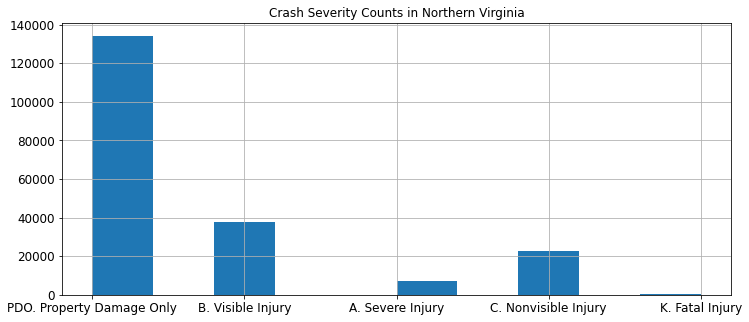

In [0]:
crashNOVA["CRASH_SEVERITY"].hist(figsize=[12, 5])
plt.title("Crash Severity Counts in Northern Virginia")

According to the above graph, the majority of crashes result in only property damage. As we expected, there are fewer fatal/severe injury crashes than there are minor or property-only damages.

We follow these plots with maps of our crash data, where each point is sized based on the number of people injured and colored based on crash severity. The first plot is for the entire dataset in Virginia and the second plot is isolated to just Northern Virginia.

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


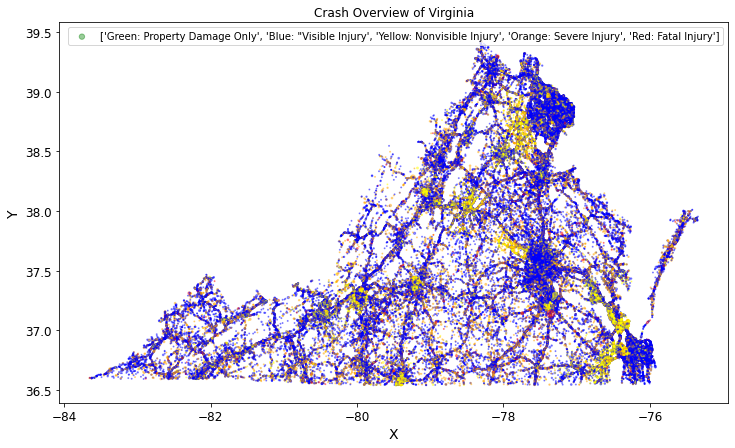

In [0]:
# Source: https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib
colors = {'PDO. Property Damage Only': 'Green', 'B. Visible Injury': 'Blue',
          'C. Nonvisible Injury': 'Yellow', 'A. Severe Injury': 'Orange',
          'K. Fatal Injury': 'Red'}
crash.plot(kind="scatter", x="X", y="Y", alpha=0.4,
    s=crash["PERSONS_INJURED"], figsize=(12,7),
    c=crash["CRASH_SEVERITY"].apply(lambda x: colors[x]),
    label=['Green: Property Damage Only',
           'Blue: "Visible Injury',
           'Yellow: Nonvisible Injury',
           'Orange: Severe Injury',
           'Red: Fatal Injury'],
    title="Crash Overview of Virginia",
    sharex=False)
plt.legend()

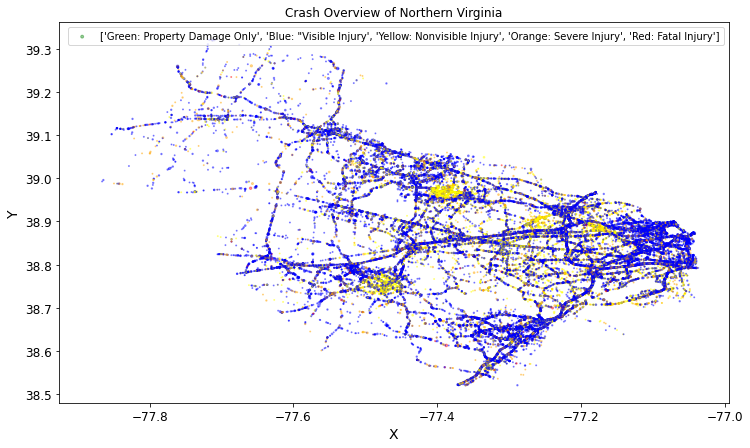

In [0]:
crashNOVA.plot(kind="scatter", x="X", y="Y", alpha=0.4,
    s=crashNOVA["PERSONS_INJURED"], figsize=(12,7),
    c=crashNOVA["CRASH_SEVERITY"].apply(lambda x: colors[x]),
    label=['Green: Property Damage Only',
           'Blue: "Visible Injury',
           'Yellow: Nonvisible Injury',
           'Orange: Severe Injury',
           'Red: Fatal Injury'],
    title="Crash Overview of Northern Virginia",
    sharex=False)
plt.legend()

The plots reaffirm what we discovered through our histograms. Additionally, we believe the plots highlight the frequency of crashes that appear to occur on highways. Lastly, it appears that non-visible injuries from crashes (the yellow points on our plots) occur in particular clusters, both throughout Virginia and specifically in NOVA.

For further data insight analysis, we can compare the frequencies of crash severity depending on other categorical features in our dataset. Primarily, we looked at the road type (e.g., Interstate, Primary, Secondary) to determine if one system is more susceptible to a particular crash type than another. We've included both the histograms and the explicit frequency counts based on the system type.

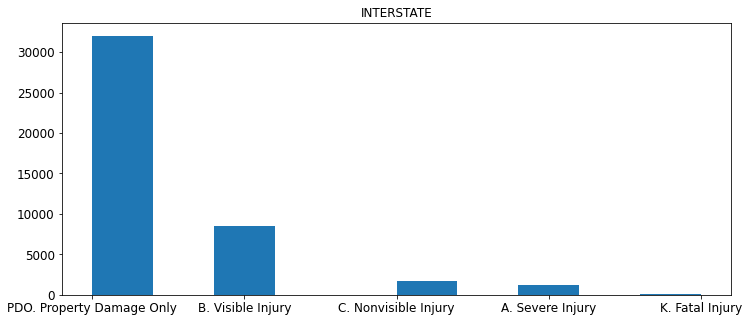

PDO. Property Damage Only    32000
B. Visible Injury             8484
C. Nonvisible Injury          1705
A. Severe Injury              1206
K. Fatal Injury                 77
Name: CRASH_SEVERITY, dtype: int64


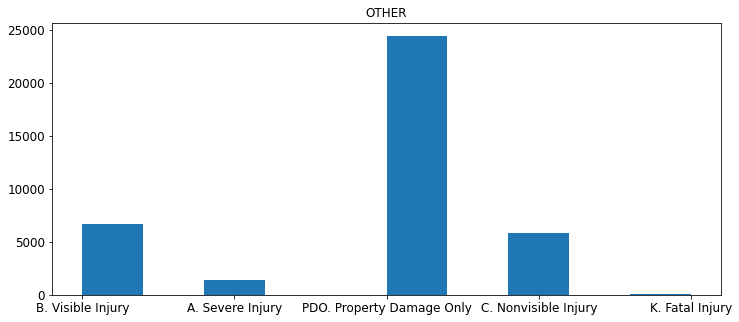

PDO. Property Damage Only    24429
B. Visible Injury             6692
C. Nonvisible Injury          5850
A. Severe Injury              1439
K. Fatal Injury                 71
Name: CRASH_SEVERITY, dtype: int64


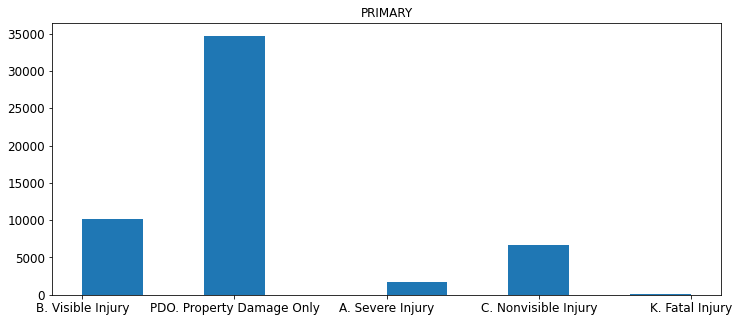

PDO. Property Damage Only    34680
B. Visible Injury            10145
C. Nonvisible Injury          6656
A. Severe Injury              1757
K. Fatal Injury                168
Name: CRASH_SEVERITY, dtype: int64


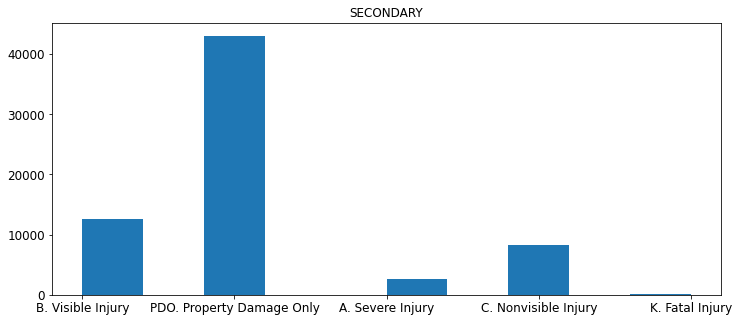

PDO. Property Damage Only    43034
B. Visible Injury            12535
C. Nonvisible Injury          8275
A. Severe Injury              2642
K. Fatal Injury                215
Name: CRASH_SEVERITY, dtype: int64


In [0]:
# Source: https://stackoverflow.com/questions/58352904/how-to-change-the-dimensions-of-a-histogram-depicted-by-plt-hist-as-figsize-is
#         https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
systems = crashNOVA.groupby("SYSTEM")
for name, group in systems:
  plt.figure(figsize=(12, 5))
  plt.title(name)
  plt.hist(group['CRASH_SEVERITY'])
  plt.show()
  print(group['CRASH_SEVERITY'].value_counts())

We can take away multiple points from the above analysis:
*   Interstates appear to have fewer nonvisible injury crashes than all other road types/systems
*   Secondary systems (e.g., highways) have the most of each type of crash compared to all other road systems
*   Primary systems (e.g., state-maintained) have more visible injury crashes than interstate systems



# **STEP 4: Preparing the Data for Machine Learning Algorithms**

Below is our data cleaning process. We isolate our data of interest, eliminate variables based on lack of clarity or lack of usefulness, remove empty values, split the data into training and test set data, and then scale or encode our variables (depending on if the variable is quantitative or qualitative).

In [0]:
# https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/
crashNOVA = crash[crash['VDOT_DISTRICT'] == '9. Northern Virginia']
cleanedNOVA = crashNOVA.drop(columns=["LAT", "LON", "OBJECTID", "DOCUMENT_NBR", "CRASH_YEAR", "CRASH_DT",
                                   "RD_TYPE", "WORK_ZONE_LOCATION", "WORK_ZONE_TYPE", 'NODE', 'OFFSET',
                                   "VDOT_DISTRICT", "JURIS_CODE", "LOCAL_CASE_CD", 'VSP',
                                   "MPO_NAME", 'PLAN_DISTRICT', 'RNS_MP', 'RTE_NM',
                                   'ROUTE_OR_STREET_NM', 'INTERSECTION_ANALYSIS',
                                   'OWNERSHIP'])
cleanedNOVA.head()

,X,Y,CRASH_MILITARY_TM,CRASH_SEVERITY,K_PEOPLE,A_PEOPLE,B_PEOPLE,C_PEOPLE,PERSONS_INJURED,PEDESTRIANS_KILLED,PEDESTRIANS_INJURED,VEH_COUNT,COLLISION_TYPE,WEATHER_CONDITION,LIGHT_CONDITION,ROADWAY_SURFACE_COND,RELATION_TO_ROADWAY,ROADWAY_ALIGNMENT,ROADWAY_SURFACE_TYPE,ROADWAY_DEFECT,ROADWAY_DESCRIPTION,INTERSECTION_TYPE,TRAFFIC_CONTROL_TYPE,TRFC_CTRL_STATUS_TYPE,WORK_ZONE_RELATED,FIRST_HARMFUL_EVENT,FIRST_HARMFUL_EVENT_LOC,ALCOHOL_NOTALCOHOL,BELTED_UNBELTED,BIKE_NONBIKE,DISTRACTED_NOTDISTRACTED,DEER_NODEER,DROWSY_NOTDROWSY,DRUG_NODRUG,GR_NOGR,HITRUN_NOT_HITRUN,LGTRUCK_NONLGTRUCK,MOTOR_NONMOTOR,PED_NONPED,RR,SPEED_NOTSPEED,SCHOOL_ZONE,SENIOR_NOTSENIOR,YOUNG_NOTYOUNG,MAINLINE_YN,NIGHT,PHYSICAL_JURIS,FUN,FAC,AREA_TYPE,SYSTEM
0,-77.220320,38.866336,2202,PDO. Property Damage Only,0,0,0,0,0,0,0,2,1. Rear End,1. No Adverse Condition (Clear/Cloudy),4. Darkness - Road Lighted,1. Dry,1. Main-Line Roadway,1. Straight - Level,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"3. Two-Way, Divided, Positive Median Barrier",1. Not at Intersection,6. Traffic Lanes Marked,1. Yes - Working,2. No,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,3. No,No,No,Yes,Yes,029. Fairfax County,A. Urban Interstate,"3. Divided, full control of access",Urban,INTERSTATE
1,-77.692049,39.137436,1030,B. Visible Injury,0,0,2,0,2,0,0,2,1. Rear End,1. No Adverse Condition (Clear/Cloudy),2. Daylight,1. Dry,9. Within Intersection,1. Straight - Level,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"1. Two-Way, Not Divided",3. Three Approaches,3. Traffic Signal,1. Yes - Working,1. Yes,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,Yes,No,No,No,No,No,Yes,No,No,No,No,3. No,No,No,Yes,No,053. Loudoun County,H. Urban Minor Arterial,"0. Two-way, non-divided",Urban,PRIMARY
2,-77.182500,38.725000,1745,B. Visible Injury,0,0,1,1,2,0,0,4,1. Rear End,1. No Adverse Condition (Clear/Cloudy),4. Darkness - Road Lighted,1. Dry,10. Intersection Related - Within 150 Feet,3. Grade - Straight,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"2. Two-Way, Divided, Unprotected Median",4. Four Approaches,3. Traffic Signal,1. Yes - Working,2. No,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3. No,No,No,Yes,Yes,029. Fairfax County,H. Urban Minor Arterial,"0. Two-way, non-divided",Urban,SECONDARY
7,-77.126841,38.858957,1013,B. Visible Injury,0,0,2,1,3,0,0,2,2. Angle,1. No Adverse Condition (Clear/Cloudy),2. Daylight,1. Dry,8. Non-Intersection,3. Grade - Straight,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"1. Two-Way, Not Divided",3. Three Approaches,6. Traffic Lanes Marked,1. Yes - Working,2. No,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3. No,Yes,No,Yes,No,000. Arlington County,H. Urban Minor Arterial,"0. Two-way, non-divided",Urban,OTHER
9,-77.311592,38.868238,1303,PDO. Property Damage Only,0,0,0,0,0,0,0,4,1. Rear End,1. No Adverse Condition (Clear/Cloudy),2. Daylight,1. Dry,8. Non-Intersection,1. Straight - Level,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"3. Two-Way, Divided, Positive Median Barrier",1. Not at Intersection,6. Traffic Lanes Marked,1. Yes - Working,2. No,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,3. No,No,No,Yes,No,029. Fairfax County,A. Urban Interstate,"3. Divided, full control of access",Urban,INTERSTATE


In [0]:
cleanedNOVA.shape

(202060, 51)

In [0]:
sample_incomplete_rows = cleanedNOVA[cleanedNOVA.isnull().any(axis=1)].head()
sample_incomplete_rows

,X,Y,CRASH_MILITARY_TM,CRASH_SEVERITY,K_PEOPLE,A_PEOPLE,B_PEOPLE,C_PEOPLE,PERSONS_INJURED,PEDESTRIANS_KILLED,PEDESTRIANS_INJURED,VEH_COUNT,COLLISION_TYPE,WEATHER_CONDITION,LIGHT_CONDITION,ROADWAY_SURFACE_COND,RELATION_TO_ROADWAY,ROADWAY_ALIGNMENT,ROADWAY_SURFACE_TYPE,ROADWAY_DEFECT,ROADWAY_DESCRIPTION,INTERSECTION_TYPE,TRAFFIC_CONTROL_TYPE,TRFC_CTRL_STATUS_TYPE,WORK_ZONE_RELATED,FIRST_HARMFUL_EVENT,FIRST_HARMFUL_EVENT_LOC,ALCOHOL_NOTALCOHOL,BELTED_UNBELTED,BIKE_NONBIKE,DISTRACTED_NOTDISTRACTED,DEER_NODEER,DROWSY_NOTDROWSY,DRUG_NODRUG,GR_NOGR,HITRUN_NOT_HITRUN,LGTRUCK_NONLGTRUCK,MOTOR_NONMOTOR,PED_NONPED,RR,SPEED_NOTSPEED,SCHOOL_ZONE,SENIOR_NOTSENIOR,YOUNG_NOTYOUNG,MAINLINE_YN,NIGHT,PHYSICAL_JURIS,FUN,FAC,AREA_TYPE,SYSTEM
58,-77.450957,38.695671,2144,A. Severe Injury,0,1,0,0,1,0,0,1,9. Fixed Object - Off Road,1. No Adverse Condition (Clear/Cloudy),5. Darkness - Road Not Lighted,"11. Sand, Dirt, Gravel",1. Main-Line Roadway,4. Grade - Curve,"2. Blacktop, Asphalt, Bituminous",5. Loose Material,"1. Two-Way, Not Divided",1. Not at Intersection,1. No Traffic Control,6. No Traffic Control Device Present,2. No,2. Trees,1. On Roadway,No,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,3. No,No,No,Yes,Yes,076. Prince William County,NaN,NaN,Rural,OTHER
133,-77.378569,38.982764,717,C. Nonvisible Injury,0,0,0,2,2,0,0,2,1. Rear End,1. No Adverse Condition (Clear/Cloudy),1. Dawn,2. Wet,10. Intersection Related - Within 150 Feet,1. Straight - Level,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"3. Two-Way, Divided, Positive Median Barrier",4. Four Approaches,3. Traffic Signal,1. Yes - Working,2. No,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3. No,No,Yes,No,No,235. Town of Herndon,NaN,NaN,Urban,OTHER
147,-77.233281,38.678006,1646,PDO. Property Damage Only,0,0,0,0,0,0,0,2,1. Rear End,1. No Adverse Condition (Clear/Cloudy),2. Daylight,1. Dry,5. On Entrance/Exit Ramp,1. Straight - Level,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"3. Two-Way, Divided, Positive Median Barrier",1. Not at Intersection,6. Traffic Lanes Marked,1. Yes - Working,2. No,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,Yes,No,Yes,No,No,No,No,No,No,No,No,3. No,No,No,No,No,029. Fairfax County,NaN,NaN,Rural,INTERSTATE
189,-77.137626,38.866835,958,PDO. Property Damage Only,0,0,0,0,0,0,0,2,2. Angle,1. No Adverse Condition (Clear/Cloudy),2. Daylight,1. Dry,10. Intersection Related - Within 150 Feet,4. Grade - Curve,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"1. Two-Way, Not Divided",2. Two Approaches,6. Traffic Lanes Marked,1. Yes - Working,2. No,6. Parked Vehicle,1. On Roadway,No,No,No,Yes,No,Yes,Yes,No,No,No,No,No,No,No,3. No,Yes,No,Yes,No,000. Arlington County,NaN,NaN,Urban,OTHER
210,-77.542680,39.103602,1630,PDO. Property Damage Only,0,0,0,0,0,0,0,2,2. Angle,1. No Adverse Condition (Clear/Cloudy),4. Darkness - Road Lighted,1. Dry,1. Main-Line Roadway,3. Grade - Straight,"2. Blacktop, Asphalt, Bituminous",1. No Defects,"2. Two-Way, Divided, Unprotected Median",1. Not at Intersection,6. Traffic Lanes Marked,1. Yes - Working,2. No,20. Motor Vehicle In Transport,1. On Roadway,No,No,No,No,No,No,No,No,No,No,No,No,No,No,3. No,No,No,Yes,Yes,253. Town of Leesburg,NaN,NaN,Urban,OTHER


In [0]:
sample_incomplete_rows.shape

(5, 51)

In [0]:
cleanedNOVA = cleanedNOVA.dropna()

In [0]:
sample_incomplete_rows = cleanedNOVA[cleanedNOVA.isnull().any(axis=1)].head()
sample_incomplete_rows

,X,Y,CRASH_MILITARY_TM,CRASH_SEVERITY,K_PEOPLE,A_PEOPLE,B_PEOPLE,C_PEOPLE,PERSONS_INJURED,PEDESTRIANS_KILLED,PEDESTRIANS_INJURED,VEH_COUNT,COLLISION_TYPE,WEATHER_CONDITION,LIGHT_CONDITION,ROADWAY_SURFACE_COND,RELATION_TO_ROADWAY,ROADWAY_ALIGNMENT,ROADWAY_SURFACE_TYPE,ROADWAY_DEFECT,ROADWAY_DESCRIPTION,INTERSECTION_TYPE,TRAFFIC_CONTROL_TYPE,TRFC_CTRL_STATUS_TYPE,WORK_ZONE_RELATED,FIRST_HARMFUL_EVENT,FIRST_HARMFUL_EVENT_LOC,ALCOHOL_NOTALCOHOL,BELTED_UNBELTED,BIKE_NONBIKE,DISTRACTED_NOTDISTRACTED,DEER_NODEER,DROWSY_NOTDROWSY,DRUG_NODRUG,GR_NOGR,HITRUN_NOT_HITRUN,LGTRUCK_NONLGTRUCK,MOTOR_NONMOTOR,PED_NONPED,RR,SPEED_NOTSPEED,SCHOOL_ZONE,SENIOR_NOTSENIOR,YOUNG_NOTYOUNG,MAINLINE_YN,NIGHT,PHYSICAL_JURIS,FUN,FAC,AREA_TYPE,SYSTEM


Since there are only 5 incomplete rows, we will drop these instances from the data set. Now, we can split our data into training and test data, as seen below. We'll use stratified sampling to ensure our training set doesn't end up being entirely filled with property-damage-only severity crashes.

In [0]:
# Source: https://stackoverflow.com/questions/36997619/sklearn-stratified-sampling-based-on-a-column
from sklearn.model_selection import train_test_split 
train_set, test_set = train_test_split(cleanedNOVA, test_size=0.2, random_state=42,
                                       shuffle=True, stratify=cleanedNOVA['CRASH_SEVERITY'])
X_train = train_set.drop("CRASH_SEVERITY", axis=1);
y_train = train_set["CRASH_SEVERITY"].copy();
X_test = test_set.drop("CRASH_SEVERITY", axis=1);
y_test = test_set["CRASH_SEVERITY"].copy();

During our analysis, we realized that there was a categorical value not accounted for in our test set. However, that value related to a specific roadway type that was not found anywhere else. Therefore, we eliminated that datapoint from our test set.

In [0]:
# Source: https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
X_test2 = X_test[X_test['RELATION_TO_ROADWAY'] != '99']

# Source: https://stackoverflow.com/questions/21800169/python-pandas-get-index-of-rows-which-column-matches-certain-value
index_val = X_test.index[X_test['RELATION_TO_ROADWAY'] == '99'][0]
y_test2 = y_test[y_test.index != index_val]

Finally, we can process our training data. Numerical data will be processed using standard scaler. Categorical data will be processed using OneHotEncoder.

In [0]:
y_train.value_counts()

PDO. Property Damage Only    95696
B. Visible Injury            27086
C. Nonvisible Injury         15930
A. Severe Injury              5026
K. Fatal Injury                379
Name: CRASH_SEVERITY, dtype: int64

In [0]:
y_train.value_counts()

PDO. Property Damage Only    95696
B. Visible Injury            27086
C. Nonvisible Injury         15930
A. Severe Injury              5026
K. Fatal Injury                379
Name: CRASH_SEVERITY, dtype: int64

In [0]:
cleanedNOVA_cat = cleanedNOVA[["COLLISION_TYPE",
                               "WEATHER_CONDITION",	"LIGHT_CONDITION",
                               "ROADWAY_SURFACE_COND",	"RELATION_TO_ROADWAY",
                               "ROADWAY_ALIGNMENT",	"ROADWAY_SURFACE_TYPE",
                               "ROADWAY_DEFECT",	"ROADWAY_DESCRIPTION",
                               "INTERSECTION_TYPE",	"TRAFFIC_CONTROL_TYPE",
                               "TRFC_CTRL_STATUS_TYPE",	"WORK_ZONE_RELATED",
                               "FIRST_HARMFUL_EVENT",	"FIRST_HARMFUL_EVENT_LOC",
                               "ALCOHOL_NOTALCOHOL",	"BELTED_UNBELTED",	"BIKE_NONBIKE",
                               "DISTRACTED_NOTDISTRACTED",	"DEER_NODEER",	"DROWSY_NOTDROWSY",
                               "DRUG_NODRUG",	"GR_NOGR",	"HITRUN_NOT_HITRUN",
                               "LGTRUCK_NONLGTRUCK",	"MOTOR_NONMOTOR",	"PED_NONPED",
                               "RR",	"SPEED_NOTSPEED",	"SCHOOL_ZONE",	"SENIOR_NOTSENIOR",
                               "YOUNG_NOTYOUNG",	"MAINLINE_YN",	"NIGHT",	"PHYSICAL_JURIS",
                               "FUN",	"FAC",	"AREA_TYPE",	"SYSTEM"]]
cleanedNOVA_num = cleanedNOVA[["X","Y","CRASH_MILITARY_TM",
                               "PERSONS_INJURED","PEDESTRIANS_KILLED",
                               "PEDESTRIANS_INJURED","VEH_COUNT",
                               "K_PEOPLE", "A_PEOPLE", "B_PEOPLE", "C_PEOPLE"]]

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

cat_attribs = list(cleanedNOVA_cat)
num_attribs = list(cleanedNOVA_num)

from sklearn.compose import ColumnTransformer
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

cleanedNOVA_processed_train_X = full_pipeline.fit_transform(X_train)

In [0]:
X_train.columns

Index(['X', 'Y', 'CRASH_MILITARY_TM', 'K_PEOPLE', 'A_PEOPLE', 'B_PEOPLE',
       'C_PEOPLE', 'PERSONS_INJURED', 'PEDESTRIANS_KILLED',
       'PEDESTRIANS_INJURED', 'VEH_COUNT', 'COLLISION_TYPE',
       'WEATHER_CONDITION', 'LIGHT_CONDITION', 'ROADWAY_SURFACE_COND',
       'RELATION_TO_ROADWAY', 'ROADWAY_ALIGNMENT', 'ROADWAY_SURFACE_TYPE',
       'ROADWAY_DEFECT', 'ROADWAY_DESCRIPTION', 'INTERSECTION_TYPE',
       'TRAFFIC_CONTROL_TYPE', 'TRFC_CTRL_STATUS_TYPE', 'WORK_ZONE_RELATED',
       'FIRST_HARMFUL_EVENT', 'FIRST_HARMFUL_EVENT_LOC', 'ALCOHOL_NOTALCOHOL',
       'BELTED_UNBELTED', 'BIKE_NONBIKE', 'DISTRACTED_NOTDISTRACTED',
       'DEER_NODEER', 'DROWSY_NOTDROWSY', 'DRUG_NODRUG', 'GR_NOGR',
       'HITRUN_NOT_HITRUN', 'LGTRUCK_NONLGTRUCK', 'MOTOR_NONMOTOR',
       'PED_NONPED', 'RR', 'SPEED_NOTSPEED', 'SCHOOL_ZONE', 'SENIOR_NOTSENIOR',
       'YOUNG_NOTYOUNG', 'MAINLINE_YN', 'NIGHT', 'PHYSICAL_JURIS', 'FUN',
       'FAC', 'AREA_TYPE', 'SYSTEM'],
      dtype='object')

# **STEP 5: Select and Train a Model**

The first model we looked at was an unsupervised model. This wasn't necessarily to train a final model, but moreso for us to determine whether inherent clusters exist in our data (e.g., the clustering of non-visible injuries that we noticed in our data visualization). For this unsupervised model, we used K-Nearest Neighbors.

In [0]:
#KNN--WILL NEED TO SOURCE IN THE FUTURE
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(cleanedNOVA_processed_train_X,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
knn_train_score = cross_val_score(knn_clf, cleanedNOVA_processed_train_X, y_train, cv=3, scoring="accuracy")
knn_train_score

array([0.98952934, 0.99029955, 0.99002893])

Below is a test for another model based on logistic regression. The max_iterations was set to 500 because with the default amount (or any iterations up to 300) the model would not converge.

In [0]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", max_iter=500)
log_reg.fit(cleanedNOVA_processed_train_X, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
log_reg_train_score = cross_val_score(log_reg, cleanedNOVA_processed_train_X, y_train, cv=3, scoring="accuracy")
log_reg_train_score

array([1.        , 0.99995837, 0.99995837])

Below is the code we utilized when trying to develop an SVM model for our data. However, upon running it, the code took an extremely long amount of time, and did not converge after hours of running. Therefore, given this extended runtime and the results of our other models, we decided to not finish the running of our SVM model.

In [0]:
# Source: 'CS_4774_05_support_vector_machines.ipynb'
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import numpy as np

svm_model = SVC(kernel="rbf", gamma=5, coef0=1, C=5)
svm_model.fit(cleanedNOVA_processed_train_X, y_train)

In [0]:
svm_train_score = cross_val_score(svm_model, cleanedNOVA_processed_train_X, y_train, cv=3, scoring="accuracy")
svm_train_score

In [0]:
# Source: 'CS_4774_06_decision_trees.ipynb'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(cleanedNOVA_processed_train_X, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [0]:
tree_train_scores = cross_val_score(tree_clf, cleanedNOVA_processed_train_X, y_train, cv=3, scoring="accuracy")
tree_train_scores

array([0.96402923, 0.96407086, 0.96413331])

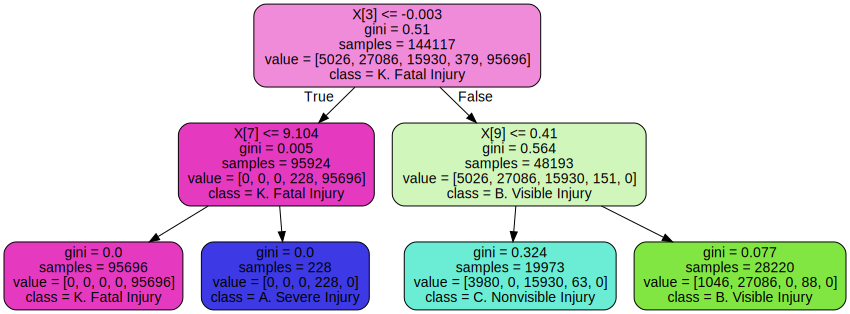

In [0]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "crash_tree.dot"),
        #feature_names=X_train.columns,
        class_names=y_train.value_counts().index,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "crash_tree.dot"))

In [0]:
print("x[3] is " + X_train.columns[3])
print("x[7] is " + X_train.columns[7])
print("x[9] is " + X_train.columns[9])

x[3] is K_PEOPLE
x[7] is PERSONS_INJURED
x[9] is PEDESTRIANS_INJURED


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

tree_clf2 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf2.fit(cleanedNOVA_processed_train_X, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

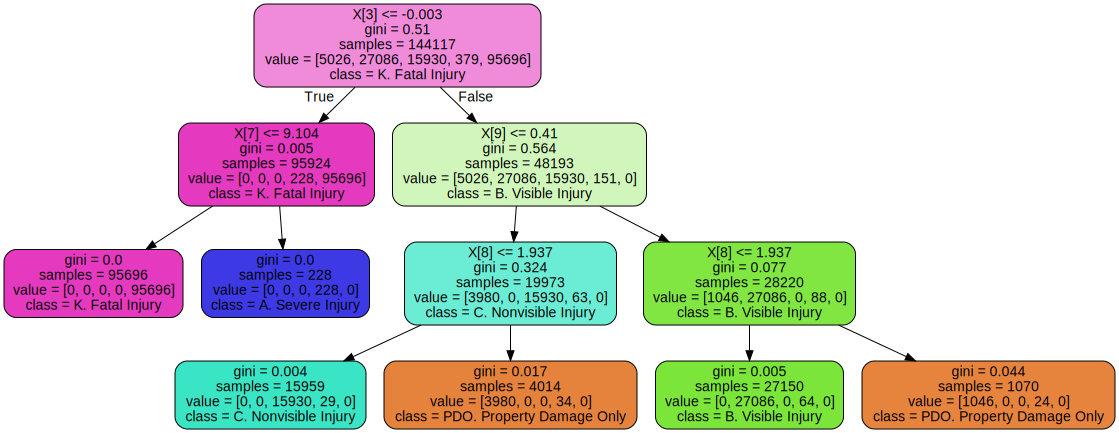

In [0]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf2,
        out_file=os.path.join(IMAGES_PATH, "crash_tree.dot"),
        #feature_names=X_train.columns,
        class_names=y_train.value_counts().index,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "crash_tree.dot"))

In [0]:
print("x[3] is " + X_train.columns[3])
print("x[7] is " + X_train.columns[7])
print("x[8] is " + X_train.columns[8])
print("x[9] is " + X_train.columns[9])

x[3] is K_PEOPLE
x[7] is PERSONS_INJURED
x[8] is PEDESTRIANS_KILLED
x[9] is PEDESTRIANS_INJURED


In [0]:
tree_train_scores2 = cross_val_score(tree_clf2, cleanedNOVA_processed_train_X, y_train, cv=3, scoring="accuracy")
tree_train_scores2

array([0.99891755, 0.99893836, 0.99900081])

# **STEP 6: Fine-Tune the Model**

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log_reg_tuned = LogisticRegression(solver="lbfgs")
param_grid_logreg = {'C': [0.001, 0.1, 1, 10], 'max_iter':[1000]}
log_model_tuning = GridSearchCV(log_reg_tuned, param_grid=param_grid_logreg,refit=True,verbose=0,cv=3)
log_model_tuning.fit(cleanedNOVA_processed_train_X, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.1, 1, 10], 'max_iter': [1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
log_reg_best = log_model_tuning.best_estimator_
log_model_tuning.best_score_

0.9999791835800079

# **STEP 7 & 8: Present and Maintain the Solution**

In [0]:
X_test_processed = full_pipeline.transform(X_test2)

In [0]:
pred_results = log_reg_best.predict(X_test_processed)

In [0]:
# Source: 'CS_4774_03_classification.ipynb'
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test2, pred_results)

array([[ 1257,     0,     0,     0,     0],
       [    0,  6771,     0,     0,     0],
       [    0,     0,  3982,     0,     0],
       [    0,     0,     0,    95,     0],
       [    0,     0,     0,     0, 23924]])

Based on the above matrix, our model achieved 100% accuracy against the test set. We decided to look into what features were deemed most important after hypertuning. The results of this analysis are below.

In [0]:
featureImportance = abs(log_model_tuning.best_estimator_.coef_)
features = np.argmax(featureImportance, axis=1)
featuresMin = np.argmin(featureImportance, axis=1)
classes = log_model_tuning.classes_
count = 0
for array in featureImportance:
  featureIndex = []
  for val in range(len(array)):
    if(array[val] > (1 ** -2)):
      featureIndex.append(X_train.columns[val])
  print(str(classes[count]) + ": Most important features are " + str(featureIndex))
  count = count + 1

print("====")

count = 0
for index in features:
  print(classes[count] + ": Most important features is " + X_train.columns[index])
  print("Max Importance: " + str(featureImportance[count][index]))
  count = count + 1


A. Severe Injury: Most important features are ['K_PEOPLE', 'PERSONS_INJURED', 'PEDESTRIANS_KILLED', 'PEDESTRIANS_INJURED']
B. Visible Injury: Most important features are ['K_PEOPLE', 'PEDESTRIANS_KILLED', 'PEDESTRIANS_INJURED']
C. Nonvisible Injury: Most important features are ['K_PEOPLE', 'PEDESTRIANS_KILLED', 'PEDESTRIANS_INJURED', 'VEH_COUNT']
K. Fatal Injury: Most important features are ['K_PEOPLE', 'PERSONS_INJURED', 'PEDESTRIANS_KILLED', 'PEDESTRIANS_INJURED']
PDO. Property Damage Only: Most important features are ['K_PEOPLE', 'PEDESTRIANS_KILLED', 'PEDESTRIANS_INJURED', 'VEH_COUNT']
====
A. Severe Injury: Most important features is PEDESTRIANS_KILLED
Max Importance: 3.8502853792733185
B. Visible Injury: Most important features is PEDESTRIANS_INJURED
Max Importance: 4.855048292587223
C. Nonvisible Injury: Most important features is PEDESTRIANS_INJURED
Max Importance: 4.463147998484327
K. Fatal Injury: Most important features is PEDESTRIANS_KILLED
Max Importance: 2.999119584510952